teams runs score prediction

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


Load data

In [10]:
matches_path = r"C:\Users\Dolli\Downloads\matches.csv"

matches_df = pd.read_csv(matches_path)

#data preparation
print(matches_df.head(5))

matches_df["date"] = pd.to_datetime(matches_df['date'])
matches_df.head(5)

       id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0        Kolkat

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [12]:
#reshape and claculate team metrics

team_performance = matches_df.melt(
    id_vars = ["id", "season" , "date" , "winner","result","result_margin","target_runs"],
    value_vars = ["team1","team2"],
    var_name ="home_or_away",
    value_name ="team"
)

team_performance["is_winner"] = (team_performance["team"] == team_performance["winner"]).astype(int)
team_performance["runs_scored"] =team_performance["target_runs"]
team_performance["runs_conceded"] = team_performance.groupby("id")["target_runs"].transform("sum") - team_performance["target_runs"]

team_performance.head(5)

,id,season,date,winner,result,result_margin,target_runs,home_or_away,team,is_winner,runs_scored,runs_conceded
0,335982,2007/08,2008-04-18,Kolkata Knight Riders,runs,140.0,223.0,team1,Royal Challengers Bangalore,0,223.0,223.0
1,335983,2007/08,2008-04-19,Chennai Super Kings,runs,33.0,241.0,team1,Kings XI Punjab,0,241.0,241.0
2,335984,2007/08,2008-04-19,Delhi Daredevils,wickets,9.0,130.0,team1,Delhi Daredevils,1,130.0,130.0
3,335985,2007/08,2008-04-20,Royal Challengers Bangalore,wickets,5.0,166.0,team1,Mumbai Indians,0,166.0,166.0
4,335986,2007/08,2008-04-20,Kolkata Knight Riders,wickets,5.0,111.0,team1,Kolkata Knight Riders,1,111.0,111.0


In [14]:
#aggreated data for each team
team_performance_agg =team_performance.groupby(["team" ,"date"]).agg({
    "is_winner":"sum",
    "runs_scored":"sum",
    "runs_conceded":"sum"
}).sort_values("date").reset_index()

team_performance_agg["net_run_rate"] =team_performance_agg["runs_scored"] - team_performance_agg["runs_conceded"]
team_performance_agg

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
0,Royal Challengers Bangalore,2008-04-18,0,223.0,223.0,0.0
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
2,Delhi Daredevils,2008-04-19,1,130.0,130.0,0.0
3,Rajasthan Royals,2008-04-19,0,130.0,130.0,0.0
4,Kings XI Punjab,2008-04-19,0,241.0,241.0,0.0
...,...,...,...,...,...,...
2185,Royal Challengers Bengaluru,2024-05-22,0,173.0,173.0,0.0
2186,Rajasthan Royals,2024-05-24,0,176.0,176.0,0.0
2187,Sunrisers Hyderabad,2024-05-24,1,176.0,176.0,0.0
2188,Kolkata Knight Riders,2024-05-26,1,114.0,114.0,0.0


In [16]:
team_name = "Kolkata Knight Riders"
team_data = team_performance_agg[team_performance_agg["team"] ==team_name]
team_data

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
8,Kolkata Knight Riders,2008-04-20,1,111.0,111.0,0.0
22,Kolkata Knight Riders,2008-04-26,0,148.0,148.0,0.0
30,Kolkata Knight Riders,2008-04-29,0,138.0,138.0,0.0
36,Kolkata Knight Riders,2008-05-01,0,197.0,197.0,0.0
...,...,...,...,...,...,...
2149,Kolkata Knight Riders,2024-05-03,1,170.0,170.0,0.0
2152,Kolkata Knight Riders,2024-05-05,1,236.0,236.0,0.0
2167,Kolkata Knight Riders,2024-05-11,1,158.0,158.0,0.0
2182,Kolkata Knight Riders,2024-05-21,1,160.0,160.0,0.0


In [18]:
team_data = team_data.sort_values("date")

team_data.set_index("date",inplace=True)
team_data

,team,is_winner,runs_scored,runs_conceded,net_run_rate
date,,,,,
2008-04-18,Kolkata Knight Riders,1,223.0,223.0,0.0
2008-04-20,Kolkata Knight Riders,1,111.0,111.0,0.0
2008-04-26,Kolkata Knight Riders,0,148.0,148.0,0.0
2008-04-29,Kolkata Knight Riders,0,138.0,138.0,0.0
2008-05-01,Kolkata Knight Riders,0,197.0,197.0,0.0
...,...,...,...,...,...
2024-05-03,Kolkata Knight Riders,1,170.0,170.0,0.0
2024-05-05,Kolkata Knight Riders,1,236.0,236.0,0.0
2024-05-11,Kolkata Knight Riders,1,158.0,158.0,0.0


In [22]:
# Select the column to predict (runs scored)
time_series = team_data['runs_scored']

# Stationarity Check (ADF Test)
adf_result = adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] > 0.05:
    print("The series is not stationary. Differencing is required.")


ADF Statistic: -7.214074913565803
p-value: 2.1963196715517275e-10


In [24]:
if adf_result[1] >0.05:
  time_series_diff = time_series.diff().dropna()
else:
  time_series_diff = time_series


In [26]:
train_size  = int(len(time_series_diff)*0.8)

train ,test = time_series_diff[:train_size] , time_series_diff[train_size:]

In [28]:
model = ARIMA(train , order =(1,1,1))
fitted_model = model.fit()

C:\Users\Dolli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dolli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dolli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
forecast  = fitted_model.forecast(steps =len(test))
forecast.index =test.index
forecast.head(5)

C:\Users\Dolli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Dolli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


date
2021-09-23    160.975878
2021-09-26    166.173245
2021-09-28    166.570630
2021-10-01    166.601014
2021-10-03    166.603337
Name: predicted_mean, dtype: float64

In [32]:
import numpy as np
actual_runs = test.values
forecast_runs = forecast.values

mae = np.mean(np.abs(actual_runs - forecast_runs))
print(f"Mean Absolute Error (MAE): ",mae )
rmse  = np.sqrt(np.mean((actual_runs - forecast_runs)**2))
print(f"Root Mean Squared Error (RMSE): ",rmse )


Mean Absolute Error (MAE):  28.842283375798786
Root Mean Squared Error (RMSE):  37.521376529995216


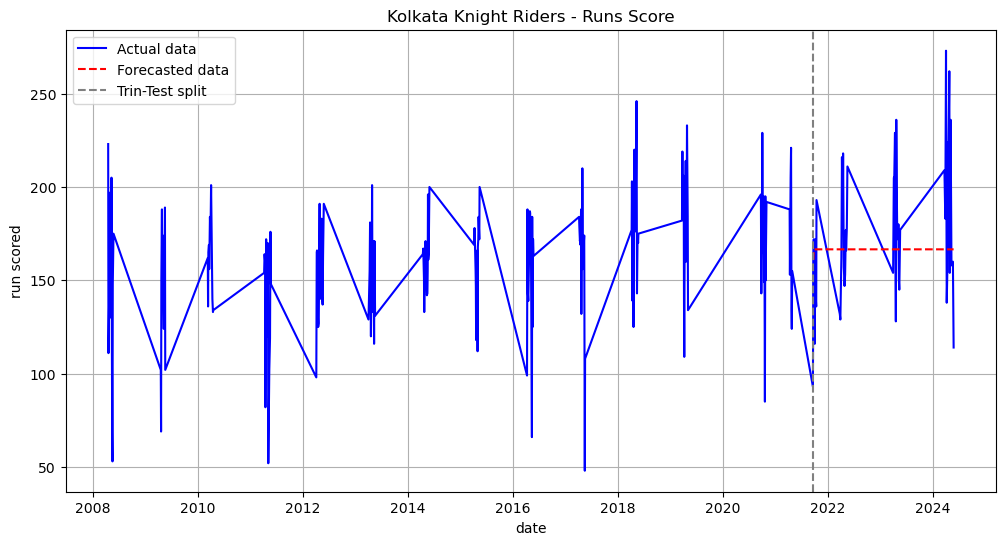

In [34]:
plt.figure(figsize = (12, 6))
plt.plot(time_series_diff , label ="Actual data" , color ="blue")
plt.plot(forecast ,label ="Forecasted data" , color="red", linestyle ="--")
plt.axvline(x =test.index[0], color="gray", linestyle = "--",label = "Trin-Test split")
plt.title(f"{team_name} - Runs Score")
plt.xlabel("date")
plt.ylabel("run scored")
plt.legend()
plt.grid()
plt.show()
